In [1]:
import networkx as nx
import EoN
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import defaultdict
import numpy as np
import random
import pandas as pd
import time
from tqdm import tqdm
from itertools import combinations
import pandas as pd

import matplotlib as mpl
import datetime
import scipy.stats
from matplotlib.dates import (YEARLY, DateFormatter,
                              rrulewrapper, RRuleLocator, drange)

import seaborn as sns
mpl.rcParams.update(mpl.rcParamsDefault)
inline_rc = dict(mpl.rcParams)

# functions

In [2]:
## function for update the inforamation of each node
def update_time(reulst, G, N, upper_bound = 10000):
    for i in range(N):
        if G._node[i]['status'] == "S":
            for j in range(1, len(reulst.node_history(i)[0])):
                if reulst.node_history(i)[0][j] <= upper_bound:
                    G._node[i].update({reulst.node_history(i)[1][j]: 
                                       reulst.node_history(i)[0][j]})
        elif G._node[i]['status'] == "E":
            for j in range(1, len(reulst.node_history(i)[0])):
                if reulst.node_history(i)[0][j] <= upper_bound:
                    G._node[i].update({reulst.node_history(i)[1][j]: 
                                       reulst.node_history(i)[0][j]})
        elif G._node[i]['status'] == "I":
            for j in range(1, len(reulst.node_history(i)[0])):
                if reulst.node_history(i)[0][j] <= upper_bound:
                    G._node[i].update({reulst.node_history(i)[1][j]: 
                                       reulst.node_history(i)[0][j]})
                                   
def update_status(G, N):
    for i in range(N):
        if G._node[i]['R']> -0.1:
            G._node[i].update({'status': "R"})
        elif G._node[i]['I']> - 0.1:
            G._node[i].update({'status': "I"})
        elif G._node[i]['E'] > -0.1:
             G._node[i].update({'status': "E"})
            
def update_from(result, G, upper_bound = 10000):
    for i in range(len(result.transmissions())):
        j = result.transmissions()[i][2]
        if G._node[j]['From'] == -1:
            if result.transmissions()[i][0]<= upper_bound:
                G._node[j].update({'From': result.transmissions()[i][1]})

In [3]:
## function to analyze the list
def mean_var_std(list_aim):
    return(round(np.mean(list_aim),3),
           round(np.var(list_aim),3),
           round(np.std(list_aim),3))


In [4]:
 def N_average_move(input_list, average_num):
    cumsum = [0]
    if average_num == 3:
        moving_aves = [sum(input_list[:2])/2]
    if average_num == 5:
        moving_aves = [sum(input_list[:3])/3]
        moving_aves.append(sum(input_list[:4])/4)
    if average_num == 7:
        moving_aves = [sum(input_list[:4])/4]
        moving_aves.append(sum(input_list[:5])/5)
        moving_aves.append(sum(input_list[:6])/6)
    if average_num == 9:
        moving_aves = [sum(input_list[:5])/5]
        moving_aves.append(sum(input_list[:6])/6)
        moving_aves.append(sum(input_list[:7])/7)
        moving_aves.append(sum(input_list[:8])/8)
    for i, x in enumerate(input_list, 1):
        cumsum.append(cumsum[i-1] + x)
        if i>=average_num:
            moving_ave = (cumsum[i] - cumsum[i-average_num])/average_num
            #can do stuff with moving_ave here
            moving_aves.append(moving_ave)
    if average_num == 3:
        moving_aves.append(sum(input_list[-2:])/2)
    elif average_num == 5:
        moving_aves.append(sum(input_list[-4:])/4)
        moving_aves.append(sum(input_list[-3:])/3)
    elif average_num == 7:
        moving_aves.append(sum(input_list[-6:])/6)
        moving_aves.append(sum(input_list[-5:])/5)
        moving_aves.append(sum(input_list[-4:])/4)
    else:
        moving_aves.append(sum(input_list[-8:])/8)
        moving_aves.append(sum(input_list[-7:])/7)
        moving_aves.append(sum(input_list[-6:])/6)
        moving_aves.append(sum(input_list[-5:])/5)
    
    return(moving_aves)

In [5]:
## plot the figure
def plot_mean_uppper_lower (fgure_for_plot, t_list_stand, S_list_stand, I_list_stand, finished_time, social_apply_time):
    
    S_mean = [np.mean(S_list_stand[i][1:]) for i in range(len(S_list_stand))]
    S_lowerbound  = [np.quantile(S_list_stand[i][1:], 0.05) for i in range(len(S_list_stand))]
    S_upperbound  = [np.quantile(S_list_stand[i][1:], 0.95) for i in range(len(S_list_stand))]
    I_mean = [np.mean(I_list_stand[i][1:]) for i in range(len(I_list_stand))]

    fi_in =t_list_stand.index(min(t_list_stand,key=lambda x:abs(x-finished_time)))

    fgure_for_plot.plot(t_list_stand[:fi_in], S_mean[:fi_in], color = 'C0')
    fgure_for_plot.fill_between(t_list_stand[:fi_in], S_lowerbound[:fi_in],S_upperbound[:fi_in], facecolor = 'C0', alpha=0.5,label='90% CI Total Confimred Cases' )
    fgure_for_plot.scatter(t_list_stand[fi_in],  S_mean[fi_in], color ='C0', label = 'Total Confimred Cases \n {} nodes (Mean)'.format(round( S_mean[fi_in],2)))
    fgure_for_plot.axvline(x= np.median(social_apply_time), color= 'black', linestyle = '--', label = 'Social Distancing Starts at \n  {} days (Mean)'.format(round(social_apply_time,2)))


In [6]:
def G_for_country(number_node, num_neigbor, p_newman_po, family_size):
    neigbor = num_neigbor
    p_newman = p_newman_po
    print("generating graph G with {} nodes {} neigbor and {} newconnect".
          format(number_node, neigbor, p_newman))

    G_tem = nx.generators.random_graphs.watts_strogatz_graph(number_node, num_neigbor, p_newman_po)

    for i in range(number_node):
        G_tem._node[i].update({'name':i})
        G_tem._node[i].update({'status':'S'})
        G_tem._node[i].update({'From': -1})
        G_tem._node[i].update({'S': 0})
        G_tem._node[i].update({'E': -1})
        G_tem._node[i].update({'I': -1})
        G_tem._node[i].update({'R': -1})
    
    country_stable_edges_list = []
    country_long_dis_edges_list = []
    for i in G_tem.edges:
        tem_index = int(i[0]/family_size)
        if i[1] in  range(tem_index*family_size,tem_index*family_size+family_size):
            country_stable_edges_list.append(i)
        else:
            country_long_dis_edges_list.append(i)

    print("num orginal edges: ", len(G_tem.edges))
    print("num baxic edges: ", len(country_stable_edges_list))
    print("num long dis edges: ", len(country_long_dis_edges_list))
    
    return(G_tem,country_stable_edges_list, country_long_dis_edges_list )

In [7]:
# simulation with the end of the second stage
def SEIR_only_social_distancing(G,infected_rate, recoverey_rate,try_end_stage_one, 
                                stage_one_threshold, G_remove_list, max_time_simulation,quaran='F'):
    # the whole recored
    combine_t = []
    combine_I = []
    combine_E = []
    combine_S = []
    combine_R = []
    return_statuses = ('S', 'E', 'I', 'R')
    
    infrate = 0.019
    # build the subgraph
    H_pre = nx.DiGraph()
    H_pre.add_node('S')
    H_pre.add_edge('E', 'I', rate = infected_rate,)
    H_pre.add_edge('I', 'R', rate = recoverey_rate)
    J_pre = nx.DiGraph()
    J_pre.add_edge(('I', 'S'), ('I', 'E'), rate = infrate)
    J_pre.add_edge(('E', 'S'), ('E', 'E'), rate = infrate)
    
    
    # set inital input variables
    start_time = 0
    end_time = try_end_stage_one 
    inital_status = nx.get_node_attributes(G, 'status')
    num_node = len(G._node)
    
    final_cuc = 0
    while final_cuc < round(stage_one_threshold*num_node)+1:
        # run simulation in each time_interval before the first time threshold coming
        sim_data =  EoN.Gillespie_simple_contagion(G, H_pre, J_pre, inital_status, return_statuses,
                                                   tmin = start_time, tmax =end_time,return_full_data=True)
        tem_cuc_list = [sim_data.I().tolist()[k]+sim_data.R().tolist()[k] for k in range(len(sim_data.I()))]
        final_cuc = tem_cuc_list[-1]
    
    close_stage_1_time_index = tem_cuc_list.index(round(stage_one_threshold*num_node))+1
    close_stage_1_time = sim_data.t()[close_stage_1_time_index-1]
    
    ## updata information of each node
    update_time(sim_data, G, num_node, close_stage_1_time)
    update_status(G, num_node)
    update_from(sim_data ,G,close_stage_1_time)
    
    ## record the simiulation result
    combine_t = combine_t + sim_data.t().tolist()[:close_stage_1_time_index]
    combine_E = combine_E + sim_data.summary()[1]['E'].tolist()[:close_stage_1_time_index]
    combine_S = combine_S + sim_data.S().tolist()[:close_stage_1_time_index]
    combine_I = combine_I + sim_data.I().tolist()[:close_stage_1_time_index]
    combine_R = combine_R + sim_data.R().tolist()[:close_stage_1_time_index]
    G_1 =G.copy()
    E_case_in_sd = combine_E[-1]


    
    ## The second stage
    # Remove list from remove_list  
    for i in G_remove_list:
        G.remove_edge(*i)
    
    inital_status = nx.get_node_attributes(G, 'status')
    start_time = close_stage_1_time
    
    #if quaran == "T":
     #   J_pre.edges[(('E', 'S'), ('E', 'E'))]['rate']=0.032
      #  J_pre.edges[(('I', 'S'), ('I', 'E'))]['rate']=0.032
        
    # run the simulation of the second stage after removing edges
    sim_data =  EoN.Gillespie_simple_contagion(G, H_pre, J_pre, inital_status, return_statuses, tmin = start_time, 
                                               tmax = max_time_simulation, return_full_data = True)
    
    # updata information of each node
    update_time(sim_data, G, num_node)
    update_status(G, num_node)
    update_from(sim_data ,G)

    # record the simiulation result
    combine_t = combine_t + sim_data.t().tolist()
    combine_S = combine_S + sim_data.S().tolist()
    combine_E = combine_E + sim_data.summary()[1]['E'].tolist()
    combine_I = combine_I + sim_data.I().tolist()
    combine_R = combine_R + sim_data.R().tolist()
    
    return(combine_t,combine_S, combine_E, combine_I,combine_R,close_stage_1_time, G_1, G,sim_data, E_case_in_sd )   


In [8]:
def SEIR_social_case_multi_run(G_tem, country_stable_edges_list, country_long_dis_edges_list, threshold_social_dis,
                              policy_power, name, repeat_time, max_time_for_simulation):
    # recored each iteration and the time of new infected node
    wo_final_cumu = []
    wo_infected_peak = [] 
    wo_infected_peak_time = []
    wo_final_stop_time = []
    wo_apply_social = []
    wo_exposed_number_in_social = []

    arr_record_cumu = []
    arr_record_I = []
    arr_record_R = []

    label_plot = ['I', 'R','Cumu']
    
    ## create a same timeline for all simualtions of benchmark
    pre_t_standard = [d for d in np.arange(0, max_time_for_simulation+0.2, 0.2)]
    arr_record_cumu = []
    arr_record_I = []
    arr_record_R = []
    
    ## recored all run result in each time point
    for i in pre_t_standard:
        arr_record_cumu.append([i])
        arr_record_I.append([i])
        arr_record_R.append([i])

    # reocrd the time
    for i in tqdm(range(repeat_time)):
        G = G_tem.copy()
        N = len(G_tem.nodes())
        initial_infected_list = random.sample(range(N), round(N*rho_set))
        for i in initial_infected_list:
            G._node[i]['I'] = 0
            G._node[i]['status'] = 'I'
            G._node[i]['From'] = None

        prob_edges_remove =policy_power
        # random pick remove list from non-neighbor edages   
        G_country_remove_list = random.sample(country_long_dis_edges_list, 
                                              round(len(country_long_dis_edges_list)*prob_edges_remove))

        result = SEIR_only_social_distancing(G,tau ,gamma,30,threshold_social_dis, 
                                             G_country_remove_list, max_time_for_simulation,quaran="T")

        pre_t = result[0]
        pre_S = result[1]
        pre_I = result[3]
        pre_R = result[4]
        result_stage = result[5]
        
        infected_peak = max(pre_I)
        infected_peak_time = pre_t[pre_I.index(infected_peak)]
        final_stop_time  = pre_t[-1]

        # combine all data following the time line
        index_time_line = [pre_t.index(min(pre_t, key=lambda x:abs(x-i))) for i in pre_t_standard] 
        pre_I_standard = [pre_I[i] for i in index_time_line]
        pre_R_standard = [pre_R[i] for i in index_time_line]

        for i in range(len(pre_t_standard)):
            arr_record_cumu[i].append(pre_I_standard[i]+pre_R_standard[i])
            arr_record_I[i].append(pre_I_standard[i])
            arr_record_R[i].append(pre_R_standard[i])

        wo_final_cumu.append(pre_I[-1]+pre_R[-1] ) 
        wo_infected_peak.append(infected_peak)
        wo_infected_peak_time.append(infected_peak_time) 
        wo_final_stop_time.append(final_stop_time)
        wo_apply_social.append(result_stage)
        wo_exposed_number_in_social.append(result[9])


    fig = plt.figure(figsize = (6,4))
    ax = fig.add_subplot(111)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plot_mean_uppper_lower (ax, pre_t_standard, arr_record_cumu, arr_record_I, 
                            max_time_for_simulation,np.mean(wo_apply_social))

    
    ax.set_xlabel("Time",fontsize=14)
    ax.set_ylabel("Cases",fontsize=14)
    ax.set_title("{}: apply {} policy power when {}% cumulative cases".format(name,round(policy_power*100), round(threshold_social_dis*100,2)))
    #plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.legend(loc='lower right',fontsize = 11)
    plt.tight_layout()
    plt.show()
    
    print("The cumulative case: ", mean_var_std(wo_final_cumu))
    print("The infected peak: ", mean_var_std(wo_infected_peak))
    print("The time of infected peak:", mean_var_std(wo_infected_peak_time))
    print("The time of policy application:", mean_var_std(wo_apply_social))
    print("The exposed case when policy application:", mean_var_std(wo_exposed_number_in_social))
        
    return(pre_t_standard, arr_record_cumu, arr_record_I,wo_apply_social,wo_exposed_number_in_social)


In [9]:
# simulation with the end of the second stage
def SEIR_only_social_distancing_ps2(G,infected_rate, recoverey_rate,try_end_stage_one, G_remove_list, max_time_simulation,quaran='F'):
    # the whole recored
    combine_t = []
    combine_I = []
    combine_E = []
    combine_S = []
    combine_R = []
    return_statuses = ('S', 'E', 'I', 'R')
    
    infrate = 0.019
    # build the subgraph
    H_pre = nx.DiGraph()
    H_pre.add_node('S')
    H_pre.add_edge('E', 'I', rate = infected_rate)
    H_pre.add_edge('I', 'R', rate = recoverey_rate)
    J_pre = nx.DiGraph()
    J_pre.add_edge(('I', 'S'), ('I', 'E'), rate = infrate)
    J_pre.add_edge(('E', 'S'), ('E', 'E'), rate = infrate)
    
    
    # set inital input variables
    start_time = 0
    end_time = try_end_stage_one 
    inital_status = nx.get_node_attributes(G, 'status')
    num_node = len(G._node)
    

    sim_data =  EoN.Gillespie_simple_contagion(G, H_pre, J_pre, inital_status, return_statuses,
                                                   tmin = start_time, tmax =end_time,return_full_data=True)

    close_stage_1_time = try_end_stage_one 
    ## updata information of each node
    update_time(sim_data, G, num_node, try_end_stage_one )
    update_status(G, num_node)
    update_from(sim_data ,G,try_end_stage_one)
    
    ## record the simiulation result
    combine_t = combine_t + sim_data.t().tolist()
    combine_E = combine_E + sim_data.summary()[1]['E'].tolist()
    combine_S = combine_S + sim_data.S().tolist()
    combine_I = combine_I + sim_data.I().tolist()
    combine_R = combine_R + sim_data.R().tolist()
    G_1 =G.copy()
    E_case_in_sd = combine_E[-1]


    
    ## The second stage
    # Remove list from remove_list  
    for i in G_remove_list:
        G.remove_edge(*i)
    
    inital_status = nx.get_node_attributes(G, 'status')
    start_time = close_stage_1_time
    
    #if quaran == "T":
     #   J_pre.edges[(('E', 'S'), ('E', 'E'))]['rate']=0.032
      #  J_pre.edges[(('I', 'S'), ('I', 'E'))]['rate']=0.032
        
    # run the simulation of the second stage after removing edges
    sim_data =  EoN.Gillespie_simple_contagion(G, H_pre, J_pre, inital_status, return_statuses, tmin = start_time, 
                                               tmax = max_time_simulation, return_full_data = True)
    
    # updata information of each node
    update_time(sim_data, G, num_node)
    update_status(G, num_node)
    update_from(sim_data ,G)

    # record the simiulation result
    combine_t = combine_t + sim_data.t().tolist()
    combine_S = combine_S + sim_data.S().tolist()
    combine_E = combine_E + sim_data.summary()[1]['E'].tolist()
    combine_I = combine_I + sim_data.I().tolist()
    combine_R = combine_R + sim_data.R().tolist()
    
    return(combine_t,combine_S, combine_E, combine_I,combine_R,close_stage_1_time, G_1, G,sim_data, E_case_in_sd )   


In [10]:
def SEIR_social_case_multi_run_ps2(G_tem, country_stable_edges_list, country_long_dis_edges_list, threshold_time,
                              policy_power, name, repeat_time, max_time_for_simulation):
    # recored each iteration and the time of new infected node
    wo_final_cumu = []
    wo_infected_peak = [] 
    wo_infected_peak_time = []
    wo_final_stop_time = []
    wo_apply_social = []
    wo_exposed_number_in_social = []

    arr_record_cumu = []
    arr_record_I = []
    arr_record_R = []

    label_plot = ['I', 'R','Cumu']
    
    ## create a same timeline for all simualtions of benchmark
    pre_t_standard = [d for d in np.arange(0, max_time_for_simulation+0.2, 0.2)]
    arr_record_cumu = []
    arr_record_I = []
    arr_record_R = []
    
    ## recored all run result in each time point
    for i in pre_t_standard:
        arr_record_cumu.append([i])
        arr_record_I.append([i])
        arr_record_R.append([i])

    # reocrd the time
    for i in tqdm(range(repeat_time)):
        G = G_tem.copy()
        N = len(G_tem.nodes())
        initial_infected_list = random.sample(range(N), round(N*rho_set))
        for i in initial_infected_list:
            G._node[i]['I'] = 0
            G._node[i]['status'] = 'I'
            G._node[i]['From'] = None

        prob_edges_remove =policy_power
        # random pick remove list from non-neighbor edages   
        G_country_remove_list = random.sample(country_long_dis_edges_list, 
                                              round(len(country_long_dis_edges_list)*prob_edges_remove))

        result = SEIR_only_social_distancing_ps2(G,tau ,gamma,threshold_time,
                                             G_country_remove_list, max_time_for_simulation,quaran="T")

        pre_t = result[0]
        pre_S = result[1]
        pre_I = result[3]
        pre_R = result[4]
        result_stage = result[5]
        
        infected_peak = max(pre_I)
        infected_peak_time = pre_t[pre_I.index(infected_peak)]
        final_stop_time  = pre_t[-1]

        # combine all data following the time line
        index_time_line = [pre_t.index(min(pre_t, key=lambda x:abs(x-i))) for i in pre_t_standard] 
        pre_I_standard = [pre_I[i] for i in index_time_line]
        pre_R_standard = [pre_R[i] for i in index_time_line]

        for i in range(len(pre_t_standard)):
            arr_record_cumu[i].append(pre_I_standard[i]+pre_R_standard[i])
            arr_record_I[i].append(pre_I_standard[i])
            arr_record_R[i].append(pre_R_standard[i])

        wo_final_cumu.append(pre_I[-1]+pre_R[-1] ) 
        wo_infected_peak.append(infected_peak)
        wo_infected_peak_time.append(infected_peak_time) 
        wo_final_stop_time.append(final_stop_time)
        wo_apply_social.append(result_stage)
        wo_exposed_number_in_social.append(result[9])

    
    print("The cumulative case: ", mean_var_std(wo_final_cumu))
    print("The infected peak: ", mean_var_std(wo_infected_peak))
    print("The time of infected peak:", mean_var_std(wo_infected_peak_time))
    print("The time of policy application:", mean_var_std(wo_apply_social))
    print("The exposed case when policy application:", mean_var_std(wo_exposed_number_in_social))
        
    return(pre_t_standard, arr_record_cumu, arr_record_I,wo_apply_social,wo_exposed_number_in_social)


# Parameters setting

In [11]:
## number of nodes
N =10000 

# initial infected fraction, 1 agent
rho_set = 0.0001

#transmission rate
tau = 1/7
# the expected connecting time with neighbor before infected is 1/tau  
# the variance is 1/(tau*tau)

#recovery rate
gamma = 1/14
# the expected recovered time after infected is 1/gamma 
# the varance is 1/(gamam*gamma)

# Contact-based Networking Building 

In [49]:
## For each country, the contact-based network is constructed by the number of the mean reported contacts and the average household size

In [12]:
# Germany 
# 7.96 mean reported contacts and 2.05 average household size
G_Germany, Germany_stable_edges_list, Germany_long_dis_edges_list = G_for_country(N, 8, 0.41,3)

G_play = G_Germany.copy()
for i in Germany_long_dis_edges_list:
    G_play.remove_edge(*i)
G_subgraph = [i for i in nx.connected_components(G_play)]
G_subgraph_node_list  = [len(i) for i in G_subgraph]
print("The distribution of household size")
print(mean_var_std(G_subgraph_node_list))


generating graph G with 10000 nodes 8 neigbor and 0.41 newconnect
num orginal edges:  40000
num baxic edges:  5926
num long dis edges:  34074
The distribution of household size
(2.1, 0.783, 0.885)


In [13]:
# Ialty
# 19.77 mean reported contacts and 2.40 average household size
G_It, It_stable_edges_list, It_long_dis_edges_list =  G_for_country(N, 20, 0.31,3)

G_play = G_It.copy()
for i in  It_long_dis_edges_list:
    G_play.remove_edge(*i)
G_subgraph = [i for i in nx.connected_components(G_play)]
G_subgraph_node_list  = [len(i) for i in G_subgraph]
print("The distribution of household size")
print(mean_var_std(G_subgraph_node_list))

generating graph G with 10000 nodes 20 neigbor and 0.31 newconnect
num orginal edges:  100000
num baxic edges:  6973
num long dis edges:  93027
The distribution of household size
(2.422, 0.675, 0.821)


In [14]:
# poland
# 16.31 mean reported contacts and 2.81 average household size
G_Poland, Poland_stable_edges_list, Poland_long_dis_edges_list = G_for_country(N, 16,0.12,3)
mean_var_std([G_Poland.degree(i) for i in range(N)])
G_play = G_Poland.copy()
for i in Poland_long_dis_edges_list:
    G_play.remove_edge(*i)
G_subgraph = [i for i in nx.connected_components(G_play)]
G_subgraph_node_list  = [len(i) for i in G_subgraph]
print("The distribution of household size")
print(mean_var_std(G_subgraph_node_list))

generating graph G with 10000 nodes 16 neigbor and 0.12 newconnect
num orginal edges:  80000
num baxic edges:  8767
num long dis edges:  71233
The distribution of household size
(2.87, 0.207, 0.455)


In [15]:
# Nethelands
# 13.85 mean reported contacts and 2.23 average household size
G_Neth, Neth_stable_edges_list, Neth_long_dis_edges_list = G_for_country(N, 14, 0.36,3)
G_play = G_Neth.copy()
for i in  Neth_long_dis_edges_list:
    G_play.remove_edge(*i)
G_subgraph = [i for i in nx.connected_components(G_play)]
G_subgraph_node_list  = [len(i) for i in G_subgraph]
print("The distribution of household size")
print(mean_var_std(G_subgraph_node_list))

generating graph G with 10000 nodes 14 neigbor and 0.36 newconnect
num orginal edges:  70000
num baxic edges:  6413
num long dis edges:  63587
The distribution of household size
(2.224, 0.76, 0.872)


In [16]:
# Belgium
# 11.84 mean reported contacts and 2.36 average household size
G_Be, Be_stable_edges_list, Be_long_dis_edges_list =  G_for_country(N, 12, 0.32,3)
G_play = G_Be.copy()
for i in  Be_long_dis_edges_list:
    G_play.remove_edge(*i)
G_subgraph = [i for i in nx.connected_components(G_play)]
G_subgraph_node_list  = [len(i) for i in G_subgraph]
print("The distribution of household size")
print(mean_var_std(G_subgraph_node_list))

generating graph G with 10000 nodes 12 neigbor and 0.32 newconnect
num orginal edges:  60000
num baxic edges:  6870
num long dis edges:  53130
The distribution of household size
(2.385, 0.692, 0.832)


In [55]:
## UK 
# 11.74 mean reported contacts and 2.27 average household size
G_UK, UK_stable_edges_list, UK_long_dis_edges_list = G_for_country(N, 12,0.35,3)
    
G_play = G_UK.copy()
for i in UK_long_dis_edges_list:
    G_play.remove_edge(*i)
G_subgraph = [i for i in nx.connected_components(G_play)]
G_subgraph_node_list  = [len(i) for i in G_subgraph]
print("The distribution of household size")
print(mean_var_std(G_subgraph_node_list))

generating graph G with 10000 nodes 12 neigbor and 0.35 newconnect
num orginal edges:  60000
num baxic edges:  6467
num long dis edges:  53533
The distribution of household size
(2.248, 0.752, 0.867)


# NPIs (Non-pharmaceutical interventions) Data processing

In [ ]:
# donwload the data 
Policy_Power_check= pd.read_csv("GSI_and_cases_track.csv",header=0 )

country_name_list = ['Belgium','Italy', 'United Kingdom','Netherlands','Germany', 'Poland' ]
Be_threshold_power =[[],[],[]]
It_threshold_power = [[],[],[]]
UK_threshold_power = [[],[],[]]
Ne_threshold_power = [[],[],[]]
Ge_threshold_power = [[],[],[]]
Po_threshold_power = [[],[],[]]
Con_threshold_power  = [Be_threshold_power,It_threshold_power,UK_threshold_power,
                                Ne_threshold_power,Ge_threshold_power,Po_threshold_power]

In [67]:
## data processing
for k in range(6):
    bel_real = Policy_Power_check[Policy_Power_check['location']==country_name_list[k]]
    indexes_order=np.unique(bel_real['stringency_index'].tolist(), return_index=True)[1]
    tem_strengh = [bel_real['stringency_index'].tolist()[k] for k in sorted(indexes_order)]
    bel = [[],[],[]]
    for i in [j for j in tem_strengh if str(j) != 'nan']:
        bel[0].append(i)
        index_tem = bel_real['stringency_index'].tolist().index(i)
        bel[1].append(round(bel_real['total_cases_per_million'].tolist()[index_tem],2))
        bel[2].append(bel_real['date'].tolist()[index_tem])
    for i in range(3):
        max_index=bel[0].index(max(bel[0]))
        Con_threshold_power[k][i] = bel[i][max_index-4:max_index+1]

In [68]:
# show the first fifth highest stringencey index in each country and the corresponding date and the number of confirmed case per million
print('[Stringency_index, Total_cases_per_million, Date]')
for i in range(6):
    print(country_name_list[i])
    print(Con_threshold_power[i])

[Stringency_index, Total_cases_per_million, Date]
Belgium
[[19.44, 23.15, 50.93, 73.15, 81.48], [43.23, 88.36, 117.52, 221.23, 328.83], ['3/10/2020', '3/13/2020', '3/14/2020', '3/18/2020', '3/20/2020']]
Italy
[[74.54, 82.41, 85.19, 91.67, 93.52], [41.38, 151.7, 167.86, 678.69, 2518.47], ['3/4/2020', '3/10/2020', '3/11/2020', '3/20/2020', '4/12/2020']]
United Kingdom
[[37.04, 47.22, 62.04, 78.24, 79.63], [79.93, 95.47, 113.96, 131.6, 151.9], ['3/20/2020', '3/21/2020', '3/22/2020', '3/23/2020', '3/24/2020']]
Netherlands
[[54.63, 62.04, 70.37, 74.07, 79.63], [55.97, 66.24, 119.7, 245.35, 685.74], ['3/15/2020', '3/16/2020', '3/19/2020', '3/23/2020', '3/31/2020']]
Germany
[[52.31, 55.09, 57.87, 68.06, 76.85], [85.41, 97.85, 168.74, 217.07, 256.17], ['3/18/2020', '3/19/2020', '3/20/2020', '3/21/2020', '3/22/2020']]
Poland
[[41.67, 49.07, 57.41, 81.48, 83.33], [0.82, 1.8, 2.75, 54.3, 137.53], ['3/12/2020', '3/14/2020', '3/15/2020', '3/31/2020', '4/9/2020']]


# The example of NPIs parameters (stringency index and threshold) selection

In [57]:
Policy_Power_check = pd.read_csv("GSI_and_cases_track.csv",header=0 )

In [58]:
date_start = datetime.datetime(2019, 12, 31)
simulation_start = datetime.datetime(2020, 3, 1)
simulation_end = datetime.datetime(2020, 7, 1)
delta_each_day = datetime.timedelta(days= 1)
simualtion_dates = mpl.dates.drange(simulation_start, simulation_end, delta_each_day)
whole_days = mpl.dates.drange(date_start, simulation_end, delta_each_day)
prinr(len(simualtion_dates))

61


122

In [59]:
plt.style.use('ggplot')
plt.style.use('seaborn-white')

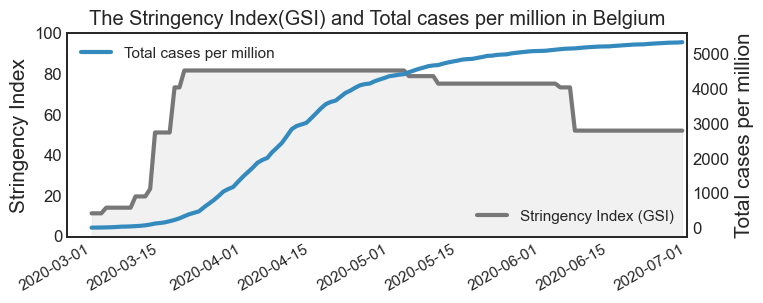

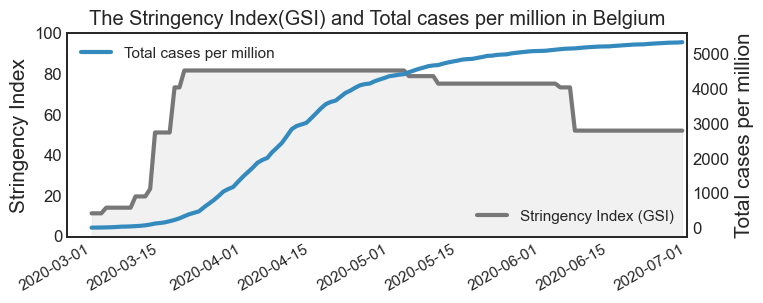

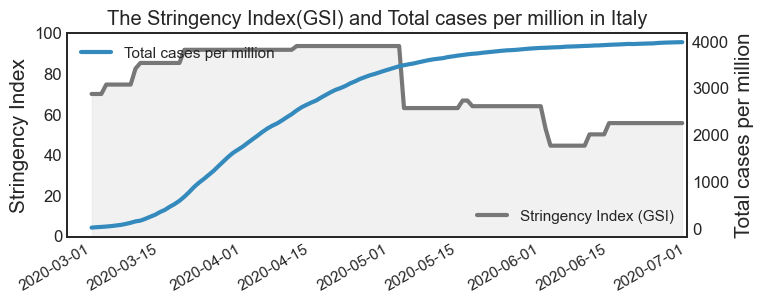

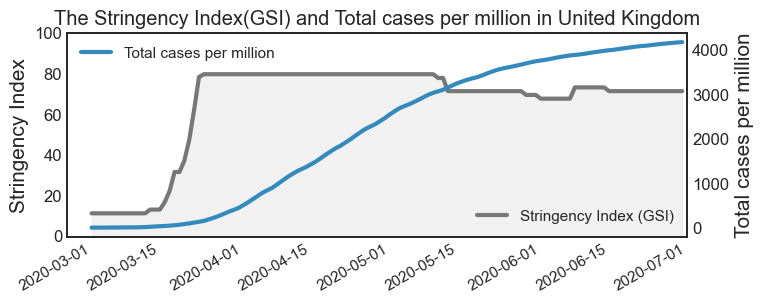

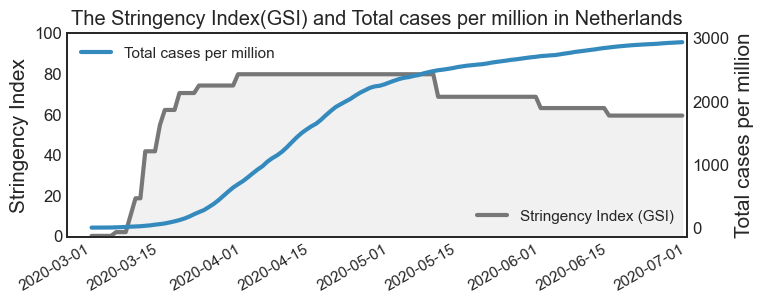

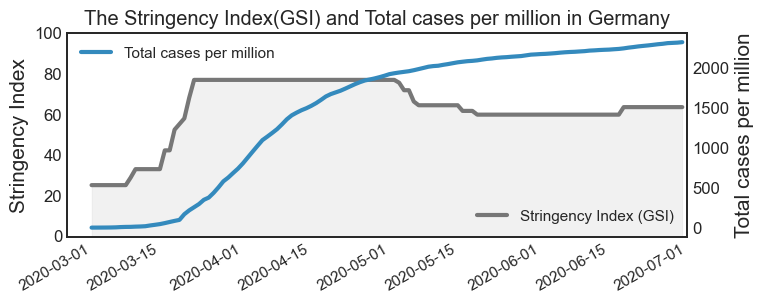

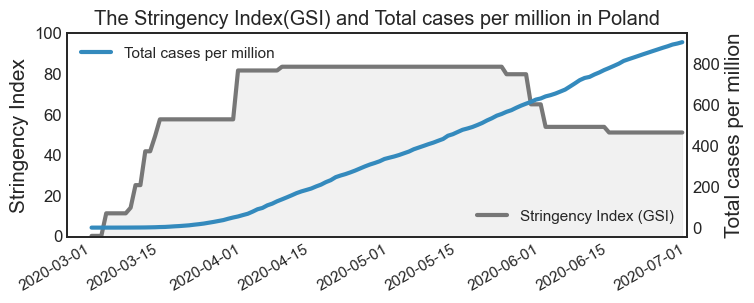

In [70]:
######## plot the track of countries
country_name_list = ['Belgium','Italy', 'United Kingdom','Netherlands','Germany', 'Poland' ]

for cou in country_name_list:
    tem_data =Policy_Power_check[Policy_Power_check['location'] == str(cou)]
    fig=plt.figure(figsize=(8,3))
    ax = fig.add_subplot(111)
    ax_poli = ax.twinx()

    ax.plot_date(simualtion_dates, 
                          tem_data['stringency_index'].tolist()[61:183], label = 'Stringency Index (GSI)',
                          linestyle = "-", marker = "", color = 'C3',lw = 3)
    ax.fill_between(simualtion_dates, tem_data['stringency_index'].tolist()[61:183],color = 'C3',alpha =0.1)
    ax_poli.plot_date(simualtion_dates, 
                          tem_data['total_cases_per_million'].tolist()[61:183], label = 'Total cases per million',
                          linestyle = "-", marker = "", color = 'C1', lw = 3)

    ax.set_ylim(-0.5,100)
    ax.set_xlim(min(simualtion_dates)-5, max(simualtion_dates)+1)


    ax.tick_params(axis='y', labelsize= 12)
    ax_poli.tick_params(axis='y', labelsize= 12)
    ax_poli.legend(loc = 'upper left',prop={'size':11})
    ax.legend(loc = 'lower right',prop={'size' :11})

    ax.set_ylabel('Stringency Index',  fontsize = 15)
    ax_poli.set_ylabel('Total cases per million', fontsize = 15)
    ax.set_title(r'The Stringency Index(GSI) and Total cases per million in {}'.format(cou))
    
    plt.setp(ax.get_xticklabels(), fontsize=11)

    plt.setp(ax.get_xticklabels(), fontsize=11)
    fig.autofmt_xdate()
    plt.show()

In [12]:
## Two example of how to select the policy parameters

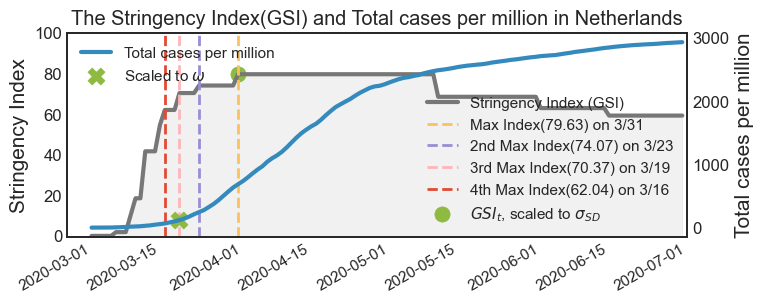

In [66]:
tem_data =Policy_Power_check[Policy_Power_check['location'] == 'Netherlands']
fig=plt.figure(figsize=(8,3))
ax = fig.add_subplot(111)
ax_poli = ax.twinx()

ax.plot_date(simualtion_dates, 
                      tem_data['stringency_index'].tolist()[61:183], label = 'Stringency Index (GSI)',
                      linestyle = "-", marker = "", color = 'C3',lw = 3)
ax.fill_between(simualtion_dates, tem_data['stringency_index'].tolist()[61:183],color = 'C3',alpha =0.1)
ax_poli.plot_date(simualtion_dates, 
                      tem_data['total_cases_per_million'].tolist()[61:183], label = 'Total cases per million',
                      linestyle = "-", marker = "", color = 'C1', lw = 3)

ax.axvline(x = datetime.datetime(2020, 3, 31), color= 'C4', linestyle = '--', label ='Max Index(79.63) on 3/31',lw = 2)
ax.axvline(x = datetime.datetime(2020, 3, 23), color= 'C9', linestyle = '--', label ='2nd Max Index(74.07) on 3/23',lw = 2)
ax.axvline(x = datetime.datetime(2020, 3, 19), color= 'C6', linestyle = '--', label ='3rd Max Index(70.37) on 3/19',lw = 2)
ax.axvline(x = datetime.datetime(2020, 3, 16), color= 'C7', linestyle = '--', label ='4th Max Index(62.04) on 3/16',lw = 2)


ax.scatter(datetime.datetime(2020, 3, 31), 79.63, color = 'C5', marker='o',s=120,label = '$GSI_t$, scaled to $\sigma_{SD}$')
ax.set_ylim(-0.5,100)
ax.set_xlim(min(simualtion_dates)-5, max(simualtion_dates)+1)

ax_poli.scatter(datetime.datetime(2020, 3, 19), 119.7, color = 'C5', marker='X',s=150, label = 'Scaled to $\omega$')


ax.tick_params(axis='y', labelsize= 12)
ax_poli.tick_params(axis='y', labelsize= 12)
ax_poli.legend(loc = 'upper left',prop={'size':11})
ax.legend(loc = 'lower right',prop={'size' :11})

ax.set_ylabel('Stringency Index',  fontsize = 15)
ax_poli.set_ylabel('Total cases per million', fontsize = 15)
ax.set_title(r'The Stringency Index(GSI) and Total cases per million in Netherlands')

plt.setp(ax.get_xticklabels(), fontsize=11)
fig.autofmt_xdate()
plt.show()

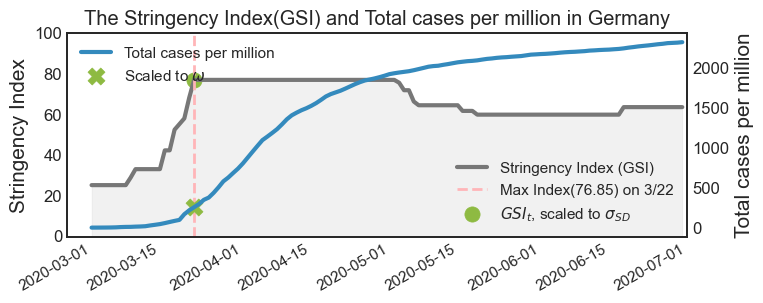

In [65]:
tem_data =Policy_Power_check[Policy_Power_check['location'] == 'Germany']
fig=plt.figure(figsize=(8,3))
ax = fig.add_subplot(111)
ax_poli = ax.twinx()

ax.plot_date(simualtion_dates, 
                      tem_data['stringency_index'].tolist()[61:183], label = 'Stringency Index (GSI)',
                      linestyle = "-", marker = "", color = 'C3',lw = 3)
ax.fill_between(simualtion_dates, tem_data['stringency_index'].tolist()[61:183],color = 'C3',alpha =0.1)
ax_poli.plot_date(simualtion_dates, 
                      tem_data['total_cases_per_million'].tolist()[61:183], label = 'Total cases per million',
                      linestyle = "-", marker = "", color = 'C1', lw = 3)

ax.axvline(x = datetime.datetime(2020, 3, 22), color= 'C6', linestyle = '--', label ='Max Index(76.85) on 3/22',lw = 2)

ax.scatter(datetime.datetime(2020, 3, 22), 76.85, color = 'C5', marker='o',s=120,label = '$GSI_t$, scaled to $\sigma_{SD}$')


ax.set_ylim(-0.5,100)
ax.set_xlim(min(simualtion_dates)-5, max(simualtion_dates)+1)

ax_poli.scatter(datetime.datetime(2020, 3, 22), 256.17, color = 'C5', marker='X',s=150, label = 'Scaled to $\omega$')


ax.tick_params(axis='y', labelsize= 12)
ax_poli.tick_params(axis='y', labelsize= 12)
ax_poli.legend(loc = 'upper left',prop={'size':11})
ax.legend(loc = 'lower right',prop={'size' :11})

ax.set_ylabel('Stringency Index',  fontsize = 15)
ax_poli.set_ylabel('Total cases per million', fontsize = 15)
ax.set_title(r'The Stringency Index(GSI) and Total cases per million in Germany')

plt.setp(ax.get_xticklabels(), fontsize=11)
fig.autofmt_xdate()
plt.show()

# network analysis before and after the social-distancing policy (after the NPIs parameter selection in the last step)

In [59]:
country_name_list = ['UK', 'Belgium','Italy', 'Netherlands','Germany', 'Poland' ]
network_for_countries = [G_UK, G_Be, G_It, G_Neth, G_Germany, G_Poland]
long_dis_for_countries = [UK_long_dis_edges_list, Be_long_dis_edges_list,
                          It_long_dis_edges_list,Neth_long_dis_edges_list, 
                          Germany_long_dis_edges_list, Poland_long_dis_edges_list]
social_dis_power_countries = [0.7963, 0.8148, 0.9352, 0.7963, 0.7685, 0.8333]

In [60]:
sd_network_for_countries = []
for i in range(6):
    tem_remove_list = random.sample( long_dis_for_countries[i], 
                              round(len(long_dis_for_countries[i])*social_dis_power_countries[i]))
    G_temcopy = network_for_countries[i].copy()
    for j in tem_remove_list:
         G_temcopy.remove_edge(*j)
    sd_network_for_countries.append(G_temcopy)

In [64]:
print('degree distribution of these six countries')
for i in range(6):
    print('"{}": {}'.format(country_name_list[i], mean_var_std([network_for_countries[i].degree(j) for j in range(N)])))
print('links distribution of these six countries')
for i in range(6):
    print('"{}" with strong {}, weak {}'.format(country_name_list[i], 
                                                len(network_for_countries[i].edges())-len(long_dis_for_countries[i]),len(long_dis_for_countries[i]) ))
    
print('average cluster of these six countries')
for i in range(6):
    print('"{}" average cluster is {}'.format(country_name_list[i], nx.average_clustering(network_for_countries[i])))
print('transitivity of these six countries')
for i in range(6):
    print('"{}" transitivity is {}'.format(country_name_list[i], nx.transitivity(network_for_countries[i])))


degree distribution of these six countries
"UK": (12.0, 3.471, 1.863)
"Belgium": (12.0, 3.23, 1.797)
"Italy": (20.0, 5.332, 2.309)
"Netherlands": (14.0, 4.241, 2.059)
"Germany": (8.0, 2.635, 1.623)
"Poland": (16.0, 1.793, 1.339)
links distribution of these six countries
"UK" with strong 6510, weak 53490
"Belgium" with strong 6771, weak 53229
"Italy" with strong 6842, weak 93158
"Netherlands" with strong 6376, weak 63624
"Germany" with strong 5912, weak 34088
"Poland" with strong 8793, weak 71207
average cluster of these six countries
"UK" average cluster is 0.1902974615906977
"Belgium" average cluster is 0.2196264833609799
"Italy" average cluster is 0.2311564598659088
"Netherlands" average cluster is 0.18409925112984682
"Germany" average cluster is 0.13538185370185246
"Poland" average cluster is 0.4806332457421596
transitivity of these six countries
"UK" transitivity is 0.18314795513129029
"Belgium" transitivity is 0.21174116432572015
"Italy" transitivity is 0.22607385431145538
"Nether

In [66]:
### after social-distacning
print('degree distribution of these six countries after social-distancing')
for i in range(6):
    print('"{}": {}'.format(country_name_list[i], mean_var_std([sd_network_for_countries[i].degree(j) for j in range(N)])))

    print('links distribution of these six countries after social-distancing')
for i in range(6):
    print('"{}" with strong {}, weak {}'.format(country_name_list[i], 
                                                len(network_for_countries[i].edges())-len(long_dis_for_countries[i]),len(long_dis_for_countries[i])*(1-social_dis_power_countries[i]) ))
print('average cluster of these six countries after social-distancing')
for i in range(6):
    print('"{}" average cluster is {}'.format(country_name_list[i], nx.average_clustering(sd_network_for_countries[i])))
print('transitivity of these six countries after social-distancing')
for i in range(6):
    print('"{}" transitivity is {}'.format(country_name_list[i], nx.transitivity(sd_network_for_countries[i])))

degree distribution of these six countries after social-distancing
"UK": (3.481, 2.239, 1.496)
links distribution of these six countries after social-distancing
"Belgium": (3.326, 2.059, 1.435)
links distribution of these six countries after social-distancing
"Italy": (2.576, 1.55, 1.245)
links distribution of these six countries after social-distancing
"Netherlands": (3.867, 2.566, 1.602)
links distribution of these six countries after social-distancing
"Germany": (2.761, 1.734, 1.317)
links distribution of these six countries after social-distancing
"Poland": (4.133, 2.177, 1.475)
links distribution of these six countries after social-distancing
"UK" with strong 6510, weak 10895.913
"Belgium" with strong 6771, weak 9858.010800000002
"Italy" with strong 6842, weak 6036.638399999997
"Netherlands" with strong 6376, weak 12960.2088
"Germany" with strong 5912, weak 7891.372000000001
"Poland" with strong 8793, weak 11870.206899999997
average cluster of these six countries after social-dist

#  Simulatie the pandenic of countries in the first 60 days. All modified SEIR models using in the following simulaiton are shown in the function section.

In [20]:
plt.rcParams.update(plt.rcParamsDefault)

In [21]:
plt.style.use('seaborn-white')

100%|██████████| 500/500 [10:11<00:00,  1.22s/it]


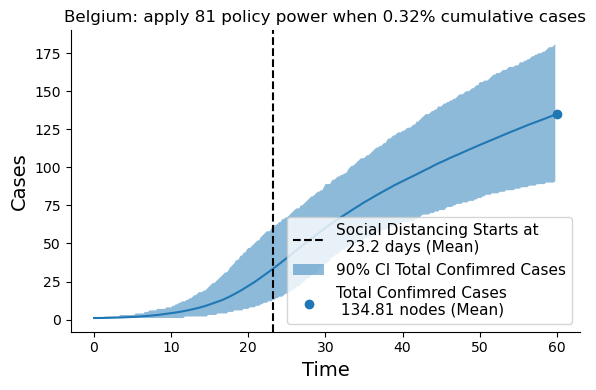

  0%|          | 0/500 [00:00<?, ?it/s]

The cumulative case:  (134.81, 786.474, 28.044)
The infected peak:  (45.996, 93.424, 9.666)
The time of infected peak: (39.88, 79.494, 8.916)
The time of policy application: (23.196, 12.431, 3.526)
The exposed case when policy application: (35.4, 88.676, 9.417)


100%|██████████| 500/500 [44:00<00:00,  5.28s/it]  


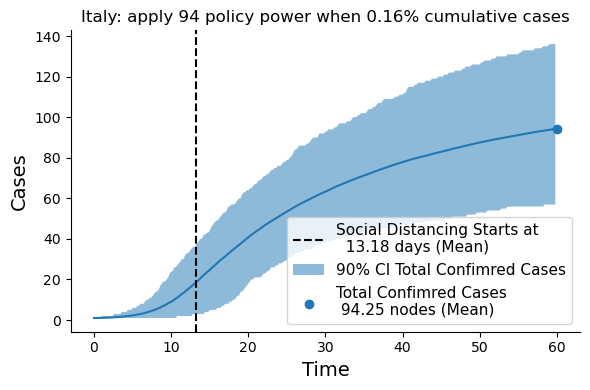

  0%|          | 0/500 [00:00<?, ?it/s]

The cumulative case:  (94.246, 646.305, 25.423)
The infected peak:  (34.498, 81.338, 9.019)
The time of infected peak: (25.302, 45.236, 6.726)
The time of policy application: (13.179, 11.938, 3.455)
The exposed case when policy application: (33.85, 117.672, 10.848)


100%|██████████| 500/500 [08:42<00:00,  1.05s/it]


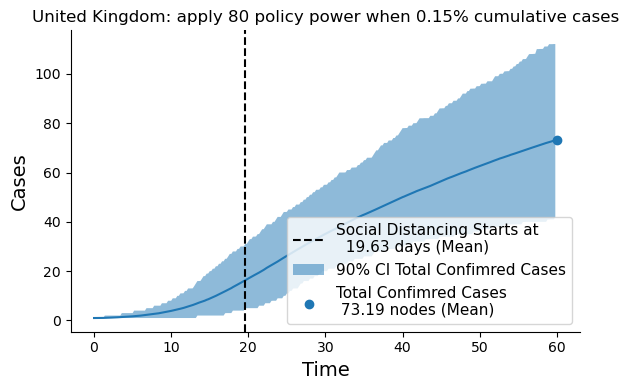

  0%|          | 0/500 [00:00<?, ?it/s]

The cumulative case:  (73.186, 525.035, 22.914)
The infected peak:  (25.2, 59.184, 7.693)
The time of infected peak: (38.706, 115.529, 10.748)
The time of policy application: (19.627, 19.044, 4.364)
The exposed case when policy application: (16.6, 41.876, 6.471)


100%|██████████| 500/500 [09:20<00:00,  1.12s/it]


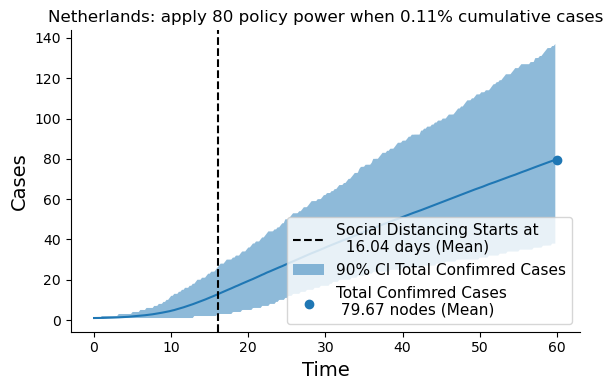

  0%|          | 0/500 [00:00<?, ?it/s]

The cumulative case:  (79.668, 994.882, 31.542)
The infected peak:  (26.406, 100.109, 10.005)
The time of infected peak: (42.273, 156.235, 12.499)
The time of policy application: (16.041, 21.268, 4.612)
The exposed case when policy application: (15.252, 42.712, 6.535)


100%|██████████| 500/500 [14:34<00:00,  1.75s/it]


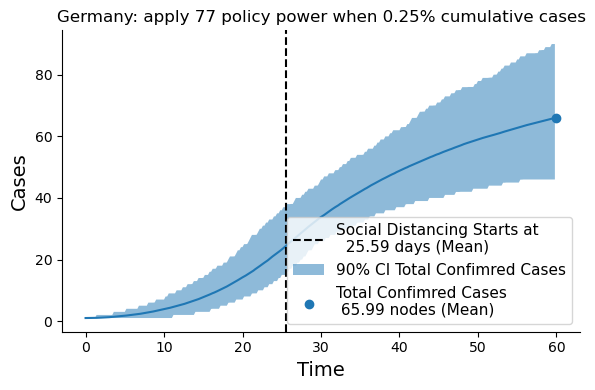

  0%|          | 0/500 [00:00<?, ?it/s]

The cumulative case:  (65.992, 170.768, 13.068)
The infected peak:  (24.476, 29.813, 5.46)
The time of infected peak: (35.708, 57.795, 7.602)
The time of policy application: (25.585, 8.235, 2.87)
The exposed case when policy application: (16.576, 30.452, 5.518)


100%|██████████| 500/500 [25:40<00:00,  3.08s/it] 


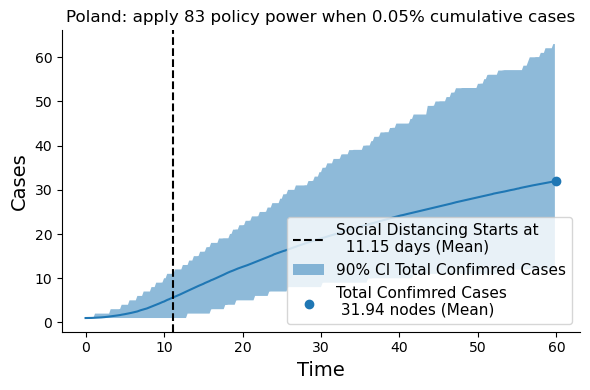

The cumulative case:  (31.942, 275.963, 16.612)
The infected peak:  (11.922, 30.992, 5.567)
The time of infected peak: (28.797, 169.597, 13.023)
The time of policy application: (11.152, 18.843, 4.341)
The exposed case when policy application: (7.186, 18.415, 4.291)


In [24]:
## number of run
tst = 500
## time of each run
tim  = 60
Be_social_dis = SEIR_social_case_multi_run(G_Be, Be_stable_edges_list, Be_long_dis_edges_list, 0.0032,
                              0.8148,'Belgium', tst ,tim)

It_social_dis = SEIR_social_case_multi_run(G_It, It_stable_edges_list, It_long_dis_edges_list, 0.0016,
                              0.9352,'Italy', tst ,tim)

UK_social_dis = SEIR_social_case_multi_run(G_UK, UK_stable_edges_list, UK_long_dis_edges_list, 0.0015,
                              0.7963,'United Kingdom', tst , tim)

neth_social_dis = SEIR_social_case_multi_run(G_Neth, Neth_stable_edges_list, Neth_long_dis_edges_list, 0.0011,
                              0.7963,'Netherlands', tst , tim)

Germany_social_dis= SEIR_social_case_multi_run(G_Germany, Germany_stable_edges_list, Germany_long_dis_edges_list, 0.0025,
                              0.7685,'Germany', tst , tim)

poland_social_dis = SEIR_social_case_multi_run(G_Poland, Poland_stable_edges_list, Poland_long_dis_edges_list, 0.0005,
                              0.8333,'Poland', tst , tim)


# save the data

In [25]:
compare_social_dis = [Be_social_dis, It_social_dis,UK_social_dis,neth_social_dis,Germany_social_dis, poland_social_dis]
country_name_list = ['Belgium','Italy','United Kingdom', 'Netherlands','Germany', 'Poland']
for i in range(6):
    np.save('500{}_final.npy'.format(country_name_list[i]),compare_social_dis[i] )

C:\Users\Qingtao\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


# Visualization of results

In [36]:
date_start = datetime.datetime(2019, 12, 31)
simulation_start = datetime.datetime(2020, 3, 2)
simulation_end = datetime.datetime(2020, 5, 1)
delta_each_day = datetime.timedelta(days= 1)
simualtion_dates = mpl.dates.drange(simulation_start, simulation_end, delta_each_day)
whole_days = mpl.dates.drange(date_start, simulation_end, delta_each_day)
len(simualtion_dates)

62


60

In [37]:
date_start = datetime.datetime(2019, 12, 31)
simulation_start = datetime.datetime(2020, 3, 1)
simulation_end = datetime.datetime(2020, 4, 30)
delta_each_day = datetime.timedelta(days= 6)
simualtion_dates_2 = mpl.dates.drange(simulation_start, simulation_end, delta_each_day)
simualtion_dates_3 = mpl.dates.drange(datetime.datetime(2020, 3, 1), datetime.datetime(2020, 4, 30), datetime.timedelta(days= 3))
simualtion_dates_4 = mpl.dates.drange(datetime.datetime(2020, 3, 1), datetime.datetime(2020, 5, 7), datetime.timedelta(days= 10))
print(len(simualtion_dates_2))
print(len(simualtion_dates_4))
print(len(simualtion_dates_3))

10
7


20

# load the result data and generate the figure for the results

In [ ]:
###load the 60 days data (or 90 days or 120 days)

In [51]:
a=np.load('epidemic/500Belgium_60.npy',allow_pickle=True)
Be_social_dis = a.tolist()
a=np.load('epidemic/500Germany_60.npy',allow_pickle=True)
Germany_social_dis = a.tolist()
a=np.load('epidemic/500Italy_60.npy',allow_pickle=True)
It_social_dis = a.tolist()
a=np.load('epidemic/500United Kingdom_60.npy',allow_pickle=True)
UK_social_dis = a.tolist()
a=np.load('epidemic/500Netherlands_60.npy',allow_pickle=True)
neth_social_dis = a.tolist()
a=np.load('epidemic/500Poland_60.npy',allow_pickle=True)
poland_social_dis = a.tolist()

In [20]:
plt.style.use('seaborn-white')

In [34]:
real_track_6 = pd.read_csv("GSI_and_cases_track.csv",header=0 )

In [ ]:
### plot the result

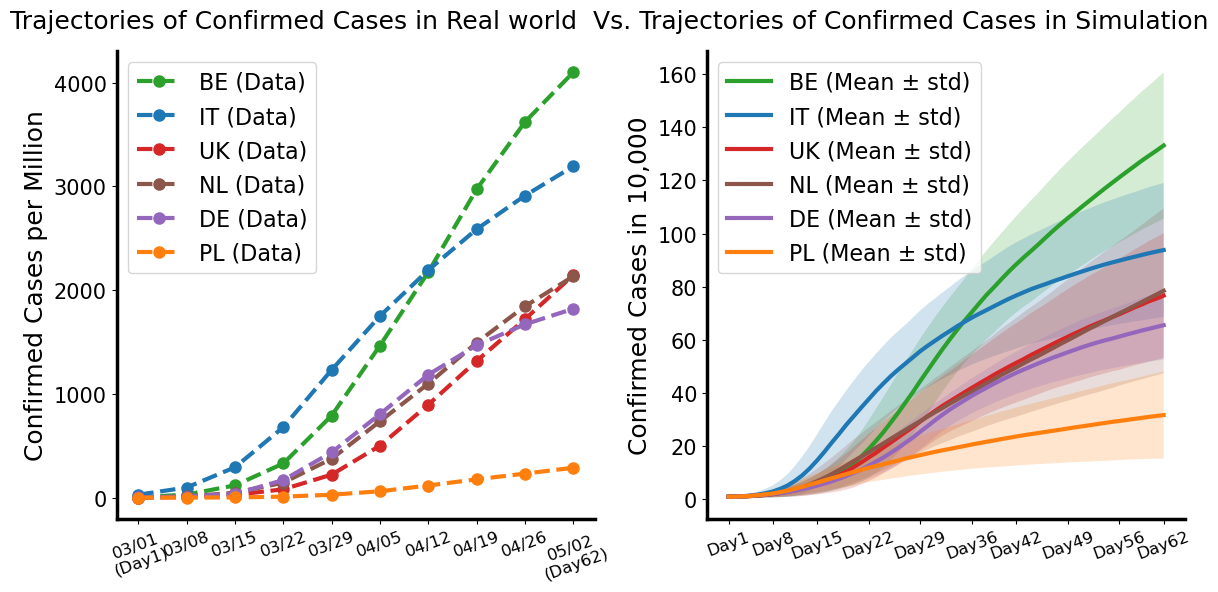

In [74]:
## conclusion of the social_distancing
##  mean and std
cmap = plt.get_cmap('tab10')
fig=plt.figure(figsize=(12,6))
ax_cumu = fig.add_subplot(121)
ax_poli = fig.add_subplot(122)
color_camp = [2,0,3,5,4,1]
compare_social_dis = [Be_social_dis, It_social_dis,UK_social_dis,neth_social_dis,
                      Germany_social_dis, poland_social_dis]
country_name_list = ['Belgium','Italy', 'United Kingdom','Netherlands','Germany', 'Poland']
country_name_list_print = ['BE','IT', 'UK','NL','DE', 'PL']
variance_order = [-1,-2,-3,-4,-1,-1]
simulation_data_set = [0,1,0,2,1,0]
simulation_data_sets = [simualtion_dates_2,simualtion_dates_3,simualtion_dates_4]
for num in range(6):
    tem_data = real_track_6[real_track_6['location'] ==country_name_list[num]]
    ax_cumu.plot_date(simualtion_dates_2, 
                      [tem_data['total_cases_per_million'].tolist()[62:122][i] for i in [k for k in  np.arange(0, 60, 6)]], 
                      label = country_name_list_print[num]+' (Data)',
                      linestyle = "--", marker='o',color= cmap(color_camp[num]),lw = 3,markersize=8)
    S_lowerbound  = [mean_var_std(compare_social_dis[num][1][i][1:])[0]-
                     mean_var_std(compare_social_dis[num][1][i][1:])[2] for i in range(len(compare_social_dis[num][1]))]
    S_upperbound  = [mean_var_std(compare_social_dis[num][1][i][1:])[0]+
                     mean_var_std(compare_social_dis[num][1][i][1:])[2] for i in range(len(compare_social_dis[num][1]))]

    ax_poli.plot_date(simualtion_dates,[np.mean(compare_social_dis[num][1][i][1:]) for i in [k for k in  np.arange(0,  300, 5)]], 
                 color = cmap(color_camp[num]),label = country_name_list_print[num]+' (Mean \u00B1 std)',linestyle = "-", marker = "",lw = 3)
    
    
    ax_poli.fill_between(simualtion_dates, [S_lowerbound[i] for i in [k for k in  np.arange(0,  300, 5)]],
                      [S_upperbound[i] for i in [k for k in  np.arange(0,300, 5)]], facecolor = cmap(color_camp[num]), alpha=0.2)

ax_cumu.set_ylabel('Confirmed Cases per Million', fontsize  = 18)
ax_poli.set_ylabel('Confirmed Cases in 10,000', fontsize  = 18)
ax_cumu.legend(prop={'size' :16})
ax_poli.legend(prop={'size' :16})


formatter = DateFormatter('%m/%d')
ax_cumu.xaxis.set_major_formatter(formatter)
ax_cumu.xaxis.set_tick_params(rotation=20, labelsize=12)
ax_poli.xaxis.set_tick_params(rotation=20, labelsize=12)

ax_cumu.set_xticks(simualtion_dates_2)
labels = ("03/01\n(Day1)", "03/08", "03/15","03/22", "03/29", "04/05","04/12","04/19","04/26","05/02\n(Day62)")
ax_cumu.set_xticklabels( labels)


ax_poli.set_xticks([simualtion_dates[i] for i in [0,6,12,19,26,33,39,46,53,59]])
labels = ("Day1", "Day8", "Day15","Day22", "Day29", "Day36","Day42", "Day49","Day56", "Day62")
ax_poli.set_xticklabels( labels)

ax_cumu.tick_params(axis='y', labelsize= 15)
ax_poli.tick_params(axis='y', labelsize= 15)


ax_cumu.spines['right'].set_visible(False)
ax_cumu.spines['top'].set_visible(False)
ax_poli.spines['right'].set_visible(False)
ax_poli.spines['top'].set_visible(False)

for axis in ['left','bottom']:
    ax_poli.spines[axis].set_linewidth(2.5)
    ax_cumu.spines[axis].set_linewidth(2.5)
    
plt.suptitle('Trajectories of Confirmed Cases in Real world  Vs. Trajectories of Confirmed Cases in Simulation',size = 18)
plt.tight_layout()
plt.show()

In [ ]:
### plot the result

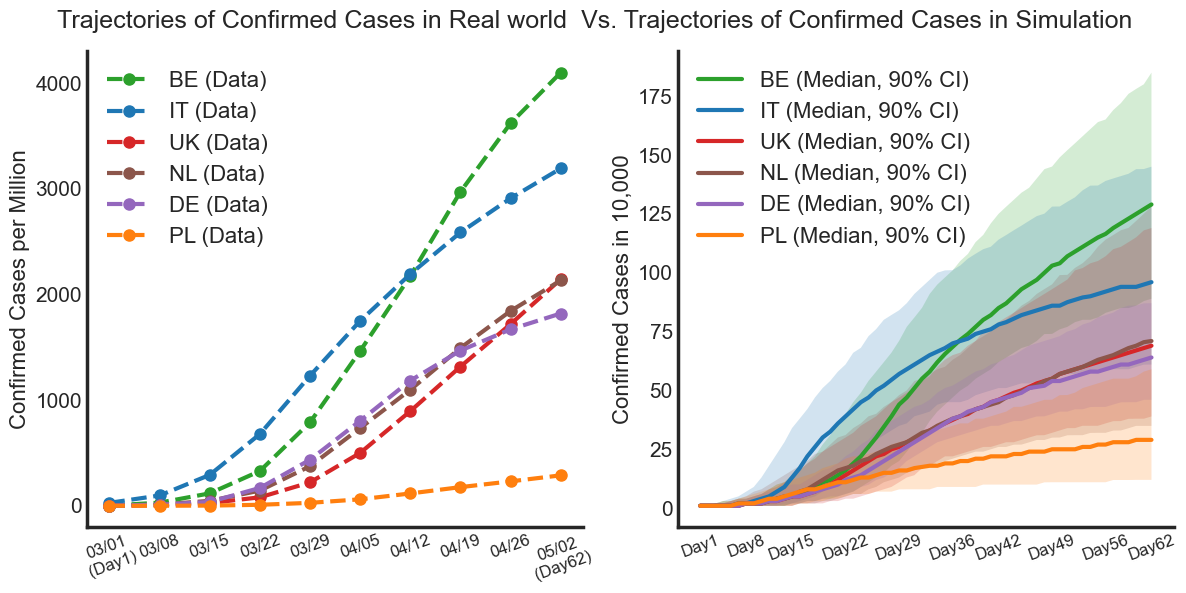

In [52]:
## conclusion of the social_distancing
## Median and 90% CI
cmap = plt.get_cmap('tab10')
fig=plt.figure(figsize=(12,6))
ax_cumu = fig.add_subplot(121)
ax_poli = fig.add_subplot(122)
color_camp = [2,0,3,5,4,1]
compare_social_dis = [Be_social_dis, It_social_dis,UK_social_dis,neth_social_dis,
                      Germany_social_dis, poland_social_dis]
country_name_list = ['Belgium','Italy', 'United Kingdom','Netherlands','Germany', 'Poland']
country_name_list_print = ['BE','IT', 'UK','NL','DE', 'PL']
variance_order = [-1,-2,-3,-4,-1,-1]
simulation_data_set = [0,1,0,2,1,0]
simulation_data_sets = [simualtion_dates_2,simualtion_dates_3,simualtion_dates_4]
for num in range(6):
    tem_data = real_track_6[real_track_6['location'] ==country_name_list[num]]
    ax_cumu.plot_date(simualtion_dates_2, 
                      [tem_data['total_cases_per_million'].tolist()[62:122][i] for i in [k for k in  np.arange(0, 60, 6)]], 
                      label = country_name_list_print[num]+' (Data)',
                      linestyle = "--", marker='o',color= cmap(color_camp[num]),lw = 3,markersize=8)

    S_lowerbound  = [np.quantile(compare_social_dis[num][1][i][1:], 0.05) for i in range(len(compare_social_dis[num][1]))]
    S_upperbound  = [np.quantile(compare_social_dis[num][1][i][1:], 0.95) for i in range(len(compare_social_dis[num][1]))]
    ax_poli.plot_date(simualtion_dates,[np.median(compare_social_dis[num][1][i][1:]) for i in [k for k in  np.arange(0,  300, 5)]], 
                 color = cmap(color_camp[num]),label = country_name_list_print[num]+' (Median, 90% CI)',linestyle = "-", marker = "",lw = 3)
    
    ax_poli.fill_between(simualtion_dates, [S_lowerbound[i] for i in [k for k in  np.arange(0,  300, 5)]],
                     [S_upperbound[i] for i in [k for k in  np.arange(0,300, 5)]], facecolor = cmap(color_camp[num]), alpha=0.2)

ax_cumu.set_ylabel('Confirmed Cases per Million', fontsize  = 16)
ax_poli.set_ylabel('Confirmed Cases in 10,000', fontsize  = 16)
ax_cumu.legend(prop={'size' :16})
ax_poli.legend(prop={'size' :16})


formatter = DateFormatter('%m/%d')
ax_cumu.xaxis.set_major_formatter(formatter)
ax_cumu.xaxis.set_tick_params(rotation=20, labelsize=12)
ax_poli.xaxis.set_tick_params(rotation=20, labelsize=12)

ax_cumu.set_xticks(simualtion_dates_2)
labels = ("03/01\n(Day1)", "03/08", "03/15","03/22", "03/29", "04/05","04/12","04/19","04/26","05/02\n(Day62)")
ax_cumu.set_xticklabels( labels)


ax_poli.set_xticks([simualtion_dates[i] for i in [0,6,12,19,26,33,39,46,53,59]])
labels = ("Day1", "Day8", "Day15","Day22", "Day29", "Day36","Day42", "Day49","Day56", "Day62")
ax_poli.set_xticklabels( labels)

ax_cumu.tick_params(axis='y', labelsize= 15)
ax_poli.tick_params(axis='y', labelsize= 15)


ax_cumu.spines['right'].set_visible(False)
ax_cumu.spines['top'].set_visible(False)
ax_poli.spines['right'].set_visible(False)
ax_poli.spines['top'].set_visible(False)

for axis in ['left','bottom']:
    ax_poli.spines[axis].set_linewidth(2.5)
    ax_cumu.spines[axis].set_linewidth(2.5)

plt.suptitle('Trajectories of Confirmed Cases in Real world  Vs. Trajectories of Confirmed Cases in Simulation',size = 18)
plt.tight_layout()
plt.show()

# Parameter Analysis

# Data generation

In [ ]:
## number of run
tst = 100
## time of each run
tim  = 100
ax_poli = fig.add_subplot(131)
HH_ps = [1.9, 2.9, 3.9]
p_ps  = [0.65,0.44, 0.18]

NPI_str = 0.9
saved_G_HH42 = []
saved_GHH42_stable_edges_list= []
saved_HH42_long_dis_edges_list = []

## Early NPIs
NPI_time = 10
for HH_picked in HH_ps :
    tin = HH_ps.index(HH_picked)
    G_HH42, HH42_stable_edges_list,HH42_long_dis_edges_list = G_for_country(N,10, p_ps[tin],4)
    saved_G_HH42.append(G_HH42)
    saved_GHH42_stable_edges_list.append(HH42_stable_edges_list)
    saved_HH42_long_dis_edges_list.append(HH42_long_dis_edges_list)
    ## Show the netwrok structure
    G_play = G_HH42.copy()
    G_play_2 = G_HH42.copy()
    for i in HH42_long_dis_edges_list:
        G_play.remove_edge(*i)
    G_subgraph = [i for i in nx.connected_components(G_play)]
    G_subgraph_node_list  = [len(i) for i in G_subgraph]
    print("The distribution of household size: ", mean_var_std(G_subgraph_node_list))
    ## simulation
    test = SEIR_social_case_multi_run_ps2(G_play_2, HH42_stable_edges_list, HH42_long_dis_edges_list, NPI_time,NPI_str,'test', tst ,tim)

    np.save("ea_npi"+level_n[tin], test)
    
## Late NPIs
NPI_time = 25    
for HH_picked in HH_ps :
    tin = HH_ps.index(HH_picked)
    ## used the generated network above
    G_HH42 = saved_G_HH42[tin]
    HH42_stable_edges_list = saved_GHH42_stable_edges_list[tin]
    HH42_long_dis_edges_list = saved_HH42_long_dis_edges_list[tin]
    G_play_2 = G_HH42.copy()
    ## simulation
    test = SEIR_social_case_multi_run_ps2(G_play_2, HH42_stable_edges_list, HH42_long_dis_edges_list, NPI_time,NPI_str,'test', tst ,tim)
    np.save("la_npi"+level_n[tin], test)

    

## No NPIs
for HH_picked in HH_ps :
    tin = HH_ps.index(HH_picked)
    ## used the generated network above
    G_HH42 = saved_G_HH42[tin]
    HH42_stable_edges_list = saved_GHH42_stable_edges_list[tin]
    HH42_long_dis_edges_list = saved_HH42_long_dis_edges_list[tin]
    G_play_2 = G_HH42.copy()
    ## simulation
    test = SEIR_social_case_multi_run_ps(G_play_2 , HH42_stable_edges_list, HH42_long_dis_edges_list, 'test', tst ,tim)
    np.save("ea_no_npi"+level_n[tin], test)


In [ ]:

## number of run
tst = 100
## time of each run
tim  = 100
## the setting of t_NPI
M_ps = [4+0.5*i for i in range(55)]
NPI_str = 0.9

G_HH42, HH42_stable_edges_list,HH42_long_dis_edges_list = G_for_country(N, 10, 0.65,4)
## Show the netwrok structure
G_play = G_HH42.copy() 
for i in HH42_long_dis_edges_list:
    G_play.remove_edge(*i)
G_subgraph = [i for i in nx.connected_components(G_play)]
G_subgraph_node_list  = [len(i) for i in G_subgraph]
print("The distribution of household size: ", mean_var_std(G_subgraph_node_list))

low_ratio_re = []
## simulation 
for M_picked in M_ps :
    G_play_2 =G_HH42.copy()
    test = SEIR_social_case_multi_run_ps2(G_play_2, HH42_stable_edges_list, HH42_long_dis_edges_list, M_picked, NPI_str,'test', tst ,tim)
    low_ratio_re.append(np.mean(test[1][-1][1:]))
np.save("low_ratio_npi_w", low_ratio_re)


G_HH42, HH42_stable_edges_list,HH42_long_dis_edges_list = G_for_country(N, 10, 0.18,4)

## Show the netwrok structure
G_play = G_HH42.copy() 
for i in HH42_long_dis_edges_list:
    G_play.remove_edge(*i)
G_subgraph = [i for i in nx.connected_components(G_play)]
G_subgraph_node_list  = [len(i) for i in G_subgraph]
print("The distribution of household size: ", mean_var_std(G_subgraph_node_list))

high_ratio_re = []
## simulation 
for M_picked in M_ps :
    G_play_2 =G_HH42.copy()
    test = SEIR_social_case_multi_run_ps2(G_play_2, HH42_stable_edges_list, HH42_long_dis_edges_list, M_picked, NPI_str,'test', tst ,tim)
    high_ratio_re.append(np.mean(test[1][-1][1:]))
np.save("high_ratio_npi_w", high_ratio_re)
    


# Plot the Scenario study Figure

In [ ]:
fig=plt.figure(figsize=(12,10),constrained_layout=True)
gs = fig.add_gridspec(4, 4)

HH_ps = [1.8, 2.8, 3.8]
p_ps  = [0.68,0.46, 0.22]
HH_ps = [1.9, 2.9, 3.9]
p_ps  = [0.65,0.45, 0.18]
NPI_time = 10
NPI_str = 0.9
level_n = ['Low', 'Medium','High']
color_order = ['C0','C2','C1']
ax_poli = fig.add_subplot(gs[-2:,:2])
for HH_picked in HH_ps :
    tin = HH_ps.index(HH_picked)
    test = np.load('ea_no_npi{}.npy'.format(level_n[tin]),allow_pickle=True)
    ax_poli.plot_date(simualtion_dates_100,[np.mean(test[1][i][1:]) for i in [k for k in  np.arange(0,  300, 3)]], 
                      label =   level_n[tin]+'  HTTCR',
                      linestyle = "-", marker = "",lw = 3, color = color_order[tin ])

ax_poli.set_title( '(c) No Social Distancing',size = 16)      
ax_poli.set_ylabel('Total Confirmed Cases', fontsize  = 16)
ax_poli.legend(loc='upper left',prop={'size' :14})
formatter = DateFormatter('%m/%d')
ax_poli.xaxis.set_tick_params(rotation=20, labelsize=13)
ax_poli.set_xticks([simualtion_dates_100[i] for i in [0,19,39,59,79,99]])
labels = ("Day1", "Day20", "Day40", "Day60", "Day80",  "Day100")
ax_poli.set_xticklabels( labels)
ax_poli.tick_params(axis='y', labelsize= 15)
ax_poli.spines['right'].set_visible(False)
ax_poli.spines['top'].set_visible(False)
for axis in ['left','bottom']:
    ax_poli.spines[axis].set_linewidth(2.5)
    

ax_poli = fig.add_subplot(gs[:2,:2])
for HH_picked in HH_ps :
    tin = HH_ps.index(HH_picked)
    test = np.load('ea_npi{}.npy'.format(level_n[tin]),allow_pickle=True)
    ax_poli.plot_date(simualtion_dates_100,[np.mean(test[1][i][1:]) for i in [k for k in  np.arange(0,  300, 3)]], 
                      label =   level_n[tin]+'  HTTCR',
                      linestyle = "-", marker = "",lw = 3, color = color_order[tin ])

    
ax_poli.axvline(x = simualtion_dates_100[NPI_time ], color= 'black', linestyle = '--', 
                label ='NPI Implemenation Day',lw =2)
ax_poli.set_title( '(a) Early Social Distancing Implementation',size = 16)  
ax_poli.set_ylabel('Total Confirmed Cases', fontsize  = 16)
ax_poli.legend(loc='lower right',prop={'size' :14})
formatter = DateFormatter('%m/%d')
ax_poli.xaxis.set_tick_params(rotation=20, labelsize=13)
ax_poli.set_xticks([simualtion_dates_100[i] for i in [0,19,39,59,79,99]])
labels = ("Day1", "Day20", "Day40", "Day60", "Day80",  "Day100")
ax_poli.set_xticklabels( labels)
ax_poli.tick_params(axis='y', labelsize= 15)
ax_poli.spines['right'].set_visible(False)
ax_poli.spines['top'].set_visible(False)
for axis in ['left','bottom']:
    ax_poli.spines[axis].set_linewidth(2.5)

ax_poli = fig.add_subplot(gs[:2,-2:])
NPI_time = 25    
for HH_picked in HH_ps :
    tin = HH_ps.index(HH_picked)
    test = np.load('la_npi{}.npy'.format(level_n[tin]),allow_pickle=True)
    ax_poli.plot_date(simualtion_dates_100,[np.mean(test[1][i][1:]) for i in [k for k in  np.arange(0,  300, 3)]],
                      label =   level_n[tin]+'  HTTCR',
                      linestyle = "-", marker = "",lw = 3, color = color_order[tin ])

    
ax_poli.axvline(x = simualtion_dates_100[NPI_time ], color= 'black', linestyle = '--', 
                label ='NPI Implemenation Day',lw =2)
ax_poli.set_title( '(b) Late Social Distancing Implementation',size = 16)
ax_poli.set_ylabel('Total Confirmed Cases', fontsize  = 16)
ax_poli.legend(loc='lower right',prop={'size' :14})
formatter = DateFormatter('%m/%d')
ax_poli.xaxis.set_tick_params(rotation=20, labelsize=13)
ax_poli.set_xticks([simualtion_dates_100[i] for i in [0,19,39,59,79,99]])
labels = ("Day1", "Day20", "Day40", "Day60", "Day80",  "Day100")
ax_poli.set_xticklabels( labels)
ax_poli.tick_params(axis='y', labelsize= 15)
ax_poli.spines['right'].set_visible(False)
ax_poli.spines['top'].set_visible(False)
for axis in ['left','bottom']:
    ax_poli.spines[axis].set_linewidth(2.5)
  
    
ax_poli = fig.add_subplot(gs[-2:, -2:])
M_ps = [4+0.5*i for i in range(55)]

low_ratio_re_la = np.load('low_ratio_npi_w.npy',allow_pickle=True)
high_ratio_re_la = np.load('high_ratio_npi_w.npy',allow_pickle=True)

low_ratio_re=N_average_move(low_ratio_re_la.tolist() ,9)
high_ratio_re= N_average_move(high_ratio_re_la.tolist(),9)

compare_re = [high_ratio_re[i]/low_ratio_re[i] for i in range(len(low_ratio_re))]
ax_poli.plot(M_ps, compare_re, label =r'$\frac{High\; HTTCR}{Low\; HTTCR}$', linewidth = 3, color = 'C5')
ax_poli.axhline(y = 1, color= 'black', linestyle = '--')
    
ax_poli.set_title('(d)',size = 16)      
ax_poli.legend(loc='lower left',prop={'size' :18})
ax_poli.set_ylabel('Ratio of Total Confirmed Cases', fontsize  = 16)
ax_poli.tick_params(axis='y', labelsize= 15)
ax_poli.set_xlabel('NPI Implemenation Day', fontsize  = 14)
ax_poli.tick_params(axis='x', labelsize= 15)

ax_poli.spines['right'].set_visible(False)
ax_poli.spines['top'].set_visible(False)
for axis in ['left','bottom']:
    ax_poli.spines[axis].set_linewidth(2.5)
tem_ylim = ax_poli.get_ylim()
    
plt.tight_layout()  
plt.show() 

# Counterfactual Analysis

In [ ]:
##### countries for six NPIs
date_start = datetime.datetime(2019, 12, 31)
simulation_start = datetime.datetime(2020, 3, 2)
simulation_end = datetime.datetime(2020, 5,1)
delta_each_day = datetime.timedelta(days= 1)
simualtion_dates = mpl.dates.drange(simulation_start, simulation_end, delta_each_day)
whole_days = mpl.dates.drange(date_start, simulation_end, delta_each_day)
len(simualtion_dates)

# Data generation

In [ ]:
## number of run
tst = 200
## time of each run
tim  = 60
Be_conclusion = [[],[],[],[],[],[]]
Be_conclusion_name = ['BE','BE_IT', 'BE_UK','BE_NL','BE_DE', 'BE_PL']
Be_conclusion[0] = SEIR_social_case_multi_run(G_Be, Be_stable_edges_list, Be_long_dis_edges_list, 0.0032,
                              0.8148,'Belgium', tst ,tim)
Be_conclusion[1]  = SEIR_social_case_multi_run(G_Be, Be_stable_edges_list, Be_long_dis_edges_list, 0.0016,
                              0.9352,'Beligum_Italy', tst ,tim)
Be_conclusion[2] = SEIR_social_case_multi_run(G_Be, Be_stable_edges_list, Be_long_dis_edges_list, 0.0015,
                              0.7963,'Beligum_United Kingdom', tst , tim)
Be_conclusion[3] = SEIR_social_case_multi_run(G_Be, Be_stable_edges_list, Be_long_dis_edges_list, 0.0011,
                              0.7963,'Beligum_Netherlands', tst , tim)
Be_conclusion[4]  = SEIR_social_case_multi_run(G_Be, Be_stable_edges_list, Be_long_dis_edges_list, 0.0025,
                              0.7685,'Beligum_Germany', tst , tim)
Be_conclusion[5]  = SEIR_social_case_multi_run(G_Be, Be_stable_edges_list, Be_long_dis_edges_list, 0.0005,
                              0.8333,'Beligum_Poland', tst , tim)

In [ ]:
## number of run
tst = 200
## time of each run
tim  = 60
DE_conclusion = [[],[],[],[],[],[]]
DE_conclusion_name = ['DE_BE','DE_IT', 'DE_UK','DE_NL','DE', 'DE_PL']
DE_conclusion[0] = SEIR_social_case_multi_run(G_Germany, Germany_stable_edges_list, Germany_long_dis_edges_list, 0.0032,
                              0.8148,'Germany_Belgium', tst ,tim)
DE_conclusion[1] = SEIR_social_case_multi_run(G_Germany, Germany_stable_edges_list, Germany_long_dis_edges_list, 0.0016,
                              0.9352,'Germany_Italy', tst ,tim)
DE_conclusion[2]= SEIR_social_case_multi_run(G_Germany, Germany_stable_edges_list, Germany_long_dis_edges_list, 0.0015,
                              0.7963,'Germany_United Kingdom', tst , tim)
DE_conclusion[3] = SEIR_social_case_multi_run(G_Germany, Germany_stable_edges_list, Germany_long_dis_edges_list, 0.0011,
                              0.7963,'Germany_Netherlands', tst , tim)
DE_conclusion[4] = SEIR_social_case_multi_run(G_Germany, Germany_stable_edges_list, Germany_long_dis_edges_list, 0.0025,
                              0.7685,'Germany', tst , tim)
DE_conclusion[5] = SEIR_social_case_multi_run(G_Germany, Germany_stable_edges_list, Germany_long_dis_edges_list, 0.0005,
                              0.8333,'Germany_Poland', tst , tim)

In [ ]:
## number of run
tst = 200
## time of each run
tim  = 60
IT_conclusion = [[],[],[],[],[],[]]
IT_conclusion_name = ['IT_BE','IT', 'IT_UK','IT_NL','IT_DE', 'IT_PL']
IT_conclusion[0] = SEIR_social_case_multi_run(G_It, It_stable_edges_list, It_long_dis_edges_list, 0.0032,
                              0.8148,'It_Belgium', tst ,tim)
IT_conclusion[1] = SEIR_social_case_multi_run(G_It, It_stable_edges_list, It_long_dis_edges_list, 0.0016,
                              0.9352,'Italy', tst ,tim)
IT_conclusion[2] = SEIR_social_case_multi_run(G_It, It_stable_edges_list, It_long_dis_edges_list, 0.0015,
                              0.7963,'It_United Kingdom', tst , tim)
IT_conclusion[3] = SEIR_social_case_multi_run(G_It, It_stable_edges_list, It_long_dis_edges_list, 0.0011,
                              0.7963,'It_Netherlands', tst , tim)
IT_conclusion[4]= SEIR_social_case_multi_run(G_It, It_stable_edges_list, It_long_dis_edges_list, 0.0025,
                              0.7685,'It_Germany', tst , tim)
IT_conclusion[5] = SEIR_social_case_multi_run(G_It, It_stable_edges_list, It_long_dis_edges_list, 0.0005,
                              0.8333,'It_Poland', tst , tim)

In [ ]:
## number of run
tst = 200
## time of each run
tim  = 60
UK_conclusion = [[],[],[],[],[],[]]
UK_conclusion_name = ['UK_BE','UK_IT', 'UK','UK_NL','UK_DE', 'UK_PL']
UK_conclusion[0] = SEIR_social_case_multi_run(G_UK, UK_stable_edges_list, UK_long_dis_edges_list, 0.0032,
                              0.8148,'UK_Belgium', tst ,tim)
UK_conclusion[1] = SEIR_social_case_multi_run(G_UK, UK_stable_edges_list, UK_long_dis_edges_list, 0.0016,
                              0.9352,'UK_Italy', tst ,tim)
UK_conclusion[2] = SEIR_social_case_multi_run(G_UK, UK_stable_edges_list, UK_long_dis_edges_list, 0.0015,
                              0.7963,'United Kingdom', tst , tim)
UK_conclusion[3] = SEIR_social_case_multi_run(G_UK, UK_stable_edges_list, UK_long_dis_edges_list, 0.0011,
                              0.7963,'UK_Netherlands', tst , tim)
UK_conclusion[4] = SEIR_social_case_multi_run(G_UK, UK_stable_edges_list, UK_long_dis_edges_list, 0.0025,
                              0.7685,'UK_Germany', tst , tim)
UK_conclusion[5] = SEIR_social_case_multi_run(G_UK, UK_stable_edges_list, UK_long_dis_edges_list, 0.0005,
                              0.8333,'UK_Poland', tst , tim)

In [ ]:
## number of run
tst = 200
## time of each run
tim  = 60
NL_conclusion = [[],[],[],[],[],[]]
NL_conclusion_name = ['NL_BE','NL_IT', 'NL_UK','NL','NL_DE', 'NL_PL']
NL_conclusion[0] = SEIR_social_case_multi_run(G_Neth, Neth_stable_edges_list, Neth_long_dis_edges_list, 0.0032,
                              0.8148,'NL_Belgium', tst ,tim)
NL_conclusion[1] = SEIR_social_case_multi_run(G_Neth, Neth_stable_edges_list, Neth_long_dis_edges_list, 0.0016,
                              0.9352,'NL_Italy', tst ,tim)
NL_conclusion[2] = SEIR_social_case_multi_run(G_Neth, Neth_stable_edges_list, Neth_long_dis_edges_list, 0.0015,
                              0.7963,'NL_United Kingdom', tst , tim)
NL_conclusion[3] = SEIR_social_case_multi_run(G_Neth, Neth_stable_edges_list, Neth_long_dis_edges_list, 0.0011,
                              0.7963,'Netherlands', tst , tim)
NL_conclusion[4] = SEIR_social_case_multi_run(G_Neth, Neth_stable_edges_list, Neth_long_dis_edges_list, 0.0025,
                              0.7685,'NL_Germany', tst , tim)
NL_conclusion[5] = SEIR_social_case_multi_run(G_Neth, Neth_stable_edges_list, Neth_long_dis_edges_list, 0.0005,
                              0.8333,'NL_Poland', tst , tim)

In [ ]:
## number of run
tst = 200
## time of each run
tim  = 60
PL_conclusion = [[],[],[],[],[],[]]
PL_conclusion_name = ['PL_BE','PL_IT', 'PL_UK','PL_NL','PL_DE', 'PL']
PL_conclusion[0] = SEIR_social_case_multi_run(G_Poland, Poland_stable_edges_list, Poland_long_dis_edges_list, 0.0032,
                              0.8148,'Belgium', tst ,tim)
PL_conclusion[1] = SEIR_social_case_multi_run(G_Poland, Poland_stable_edges_list, Poland_long_dis_edges_list, 0.0016,
                              0.9352,'Italy', tst ,tim)
PL_conclusion[2] = SEIR_social_case_multi_run(G_Poland, Poland_stable_edges_list, Poland_long_dis_edges_list, 0.0015,
                              0.7963,'United Kingdom', tst , tim)
PL_conclusion[3] = SEIR_social_case_multi_run(G_Poland, Poland_stable_edges_list, Poland_long_dis_edges_list, 0.0011,
                              0.7963,'PL_Netherlands', tst , tim)
PL_conclusion[4] = SEIR_social_case_multi_run(G_Poland, Poland_stable_edges_list, Poland_long_dis_edges_list, 0.0025,
                              0.7685,'PL_Germany', tst , tim)
PL_conclusion[5] = SEIR_social_case_multi_run(G_Poland, Poland_stable_edges_list, Poland_long_dis_edges_list, 0.0005,
                              0.8333,'Poland', tst , tim)

In [ ]:
all_conclusion = [Be_conclusion,IT_conclusion,UK_conclusion,NL_conclusion,DE_conclusion,PL_conclusion]
all_conclusion_name = [Be_conclusion_name,IT_conclusion_name,UK_conclusion_name,NL_conclusion_name,DE_conclusion_name,PL_conclusion_name]

# Plot the Counterfactual Analysis

In [ ]:
## Six NPIs applied in each country
## Median and 90% CI
cmap = plt.get_cmap('tab10')
fig=plt.figure(figsize=(14,12))
data_conclusion = [Be_conclusion,IT_conclusion, UK_conclusion,NL_conclusion,DE_conclusion,PL_conclusion]
country_name_list = ['Belgium','Italy', 'the United Kingdom','the Netherlands','Germany', 'Poland']
country_name_len = ['BE','IT', 'UK','NL','DE', 'PL']
order_len = ['(a)','(b)', '(c)', '(e)', '(f)', '(g)']
plot_list = [321+i for i in range(6)]
for coun in range(6):
    ax_poli = fig.add_subplot(plot_list[coun])
    color_camp = [2,0,3,5,4,1]
    compare_social_dis = data_conclusion[coun]
    country_name_list_print = Be_conclusion_name
    for num in range(6):
        S_lowerbound  = [mean_var_std(compare_social_dis[num][1][i][1:])[0]-
                         mean_var_std(compare_social_dis[num][1][i][1:])[2] for i in range(len(compare_social_dis[num][1]))]
        S_upperbound  = [mean_var_std(compare_social_dis[num][1][i][1:])[0]+
                         mean_var_std(compare_social_dis[num][1][i][1:])[2] for i in range(len(compare_social_dis[num][1]))]
        ax_poli.plot_date(simualtion_dates,[np.mean(compare_social_dis[num][1][i][1:]) for i in [k for k in  np.arange(0,  300, 5)]], 
                     color = cmap(color_camp[num]),label = country_name_len[num]+'_NPI (Mean \u00B1 std)',linestyle = "-", marker = "",lw = 3)    
        ax_poli.fill_between(simualtion_dates, [S_lowerbound[i] for i in [k for k in  np.arange(0,  300, 5)]],
                          [S_upperbound[i] for i in [k for k in  np.arange(0,300, 5)]], facecolor = cmap(color_camp[num]), alpha=0.2)

    ax_poli.set_ylabel('Confirmed Cases in 10,000', fontsize  = 16)
    ax_poli.legend(prop={'size' :15})
    formatter = DateFormatter('%m/%d')
    ax_poli.xaxis.set_tick_params(rotation=20, labelsize=12)
    ax_poli.set_xticks([simualtion_dates[i] for i in [0,6,12,19,26,33,39,46,53,59]])
    labels = ("Day1", "Day8", "Day15","Day22", "Day29", "Day36","Day42", "Day49","Day56", "Day62")
    ax_poli.set_xticklabels( labels)
    ax_poli.tick_params(axis='y', labelsize= 15)
    ax_poli.spines['right'].set_visible(False)
    ax_poli.spines['top'].set_visible(False)
    ax_poli.set_title('{} Different NPIs applied in {}'.format(order_len[coun], country_name_list[coun]),size= 17)
    for axis in ['left','bottom']:
        ax_poli.spines[axis].set_linewidth(2.5)


plt.suptitle('Six NPIs applied in each country',size = 18)
plt.tight_layout()
plt.show()

In [ ]:
## Each country-specific NPIs applied in countries
## Median and 90% CI
cmap = plt.get_cmap('tab10')
fig=plt.figure(figsize=(14,12))
data_conclusion = [Be_conclusion,IT_conclusion, UK_conclusion,NL_conclusion,DE_conclusion,PL_conclusion]
npi_conclusion = []
for i in range(6):
    tem_npi = []
    for j in range(6):
        tem_npi.append(data_conclusion[j][i])
    npi_conclusion.append(tem_npi)
country_name_list = ['Belgium','Italy', 'the United Kingdom','the Netherlands','Germany', 'Poland']
country_name_len = ['BE','IT', 'UK','NL','DE', 'PL']
order_len = ['(a)','(b)', '(c)', '(e)', '(f)', '(g)']
plot_list = [321+i for i in range(6)]
for coun in range(6):
    ax_poli = fig.add_subplot(plot_list[coun])
    color_camp = [2,0,3,5,4,1]
    compare_social_dis = npi_conclusion[coun]
    country_name_list_print = Be_conclusion_name
    for num in range(6):
        S_lowerbound  = [mean_var_std(compare_social_dis[num][1][i][1:])[0]-
                         mean_var_std(compare_social_dis[num][1][i][1:])[2] for i in range(len(compare_social_dis[num][1]))]
        S_upperbound  = [mean_var_std(compare_social_dis[num][1][i][1:])[0]+
                         mean_var_std(compare_social_dis[num][1][i][1:])[2] for i in range(len(compare_social_dis[num][1]))]
        ax_poli.plot_date(simualtion_dates,[np.mean(compare_social_dis[num][1][i][1:]) for i in [k for k in  np.arange(0,  300, 5)]], 
                     color = cmap(color_camp[num]),label = country_name_len[num]+' (Mean \u00B1 std)',linestyle = "-", marker = "",lw = 3)    
        ax_poli.fill_between(simualtion_dates, [S_lowerbound[i] for i in [k for k in  np.arange(0,  300, 5)]],
                          [S_upperbound[i] for i in [k for k in  np.arange(0,300, 5)]], facecolor = cmap(color_camp[num]), alpha=0.2)

    ax_poli.set_ylabel('Confirmed Cases in 10,000', fontsize  = 16)
    ax_poli.legend(prop={'size' :15})
    formatter = DateFormatter('%m/%d')
    ax_poli.xaxis.set_tick_params(rotation=20, labelsize=12)
    ax_poli.set_xticks([simualtion_dates[i] for i in [0,6,12,19,26,33,39,46,53,59]])
    labels = ("Day1", "Day8", "Day15","Day22", "Day29", "Day36","Day42", "Day49","Day56", "Day62")
    ax_poli.set_xticklabels( labels)
    ax_poli.tick_params(axis='y', labelsize= 15)
    ax_poli.spines['right'].set_visible(False)
    ax_poli.spines['top'].set_visible(False)
    ax_poli.set_title('{} {}\'s NPIs applied in countries'.format(order_len[coun], country_name_list[coun]),size= 17)
    for axis in ['left','bottom']:
        ax_poli.spines[axis].set_linewidth(2.5)


plt.suptitle('Each country-specific NPIs applied in countries',size = 18)
plt.tight_layout()
plt.show()